In [1]:
from ctypes import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage.color import rgb2lab, lab2rgb, rgb2gray, rgb2hsv
from skimage.segmentation import mark_boundaries, felzenszwalb, slic
from random import random as r
from random import uniform
import time
import matplotlib.ticker as ticker
from matplotlib.patches import ConnectionPatch

def show_inplace(image):
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
def show_inplace_g(image):
    plt.axis('off')
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
# use mean to colour the superpixel
def color_superpixels(superpixels, original):
    result = original.copy()
    rows, cols = superpixels.shape
    
    for val in np.unique(superpixels):
        pos = []
        colors = []
        for y in range(rows):
            for x in range(cols):
                if(superpixels[y][x] == val):
                    pos.append([x, y])
                    colors.append(original[y][x])
        
        avg_color = np.zeros(3)
        
        for c in colors:
            avg_color[0] += c[0]
            avg_color[1] += c[1]
            avg_color[2] += c[2]
            
        avg_color /= len(colors)
                
        for p in pos:
            result[p[1], p[0]] = avg_color
    return result

In [2]:
def fslic(img, initial_num_clusters=200, size_threshold=8, sp_control=10.0, max_iterations=10, p=0.0, q=2.0):
    h, w, depth = img.shape
    shared_file = CDLL("/home/abdelhaa/Desktop/ISFFCM/shared.so")
    shared_file.fslic.restype = POINTER(c_double * (h * w * depth))
    
    l = py_object(img.astype(c_double).flatten().tolist())
    v = shared_file.fslic(l, w, h, depth, c_int(initial_num_clusters), size_threshold, c_double(sp_control), max_iterations, c_double(p), c_double(q))
    
    result_1d = [x for x in v.contents]
    
    result = np.zeros((h, w, depth))
    
    for y in range(h):
        for x in range(w):
            for z in range(depth):
                result[y][x][z] = result_1d[(((y) * (w) * depth) + ((x) * depth) + z)]
    return result

In [3]:
def VALID(x,y,w,h):
    return 0 <= x < w and 0 <= y <h
def get_sums_and_sizes(img):
    rows, cols, depth = img.shape
    reshaped = img.reshape((rows * cols, depth))
    unique, markers = np.unique(reshaped, axis=0, return_inverse=True)
    num_regions = len(unique)
    sums = np.zeros((num_regions, depth))
    sizes = np.zeros(num_regions)
    
    for i in range(num_regions):
        mask = markers == i
        sums[i] = np.sum(reshaped[mask], axis=0)
        sizes[i] = np.count_nonzero(mask)
    return sums, sizes

def fcm_superpixels(superpixels, region_sums, region_sizes, c=2, m=2, eta=0.00001, max_iterations = 500):
    channels = superpixels.shape[-1]
    num_regions = len(region_sizes)
    
    # Exponent
    exponent = -2/(m-1)
        
    U = np.random.rand(c, num_regions).astype(float)

    for i in range(num_regions):
        U[:, i] /= np.sum(U[:, i])
    
    # Matrix of cluster centers. Each row contain 3 elements which are the coordinates of the center
    cluster_centers = np.zeros((c, channels)).astype(float)
    
    prev = U.copy()

    
    # Main LOOP begins
    for i in range(max_iterations):
        prev = U.copy()

        # Recalculate cluster centers
        for j in range(c):
            numerator = denominator = 0.0

            for k in range(num_regions):
                u_klm = U[j][k] ** m
                numerator += u_klm * region_sums[k]
                denominator += u_klm * region_sizes[k]

            cluster_centers[j] = numerator / denominator

        # Recalculate membership matrix
        for j in range(c):
            center = cluster_centers[j]

            for k in range(num_regions):
                region_avg = region_sums[k] / region_sizes[k]
                diff = region_avg - center
                numerator = np.sqrt(diff.dot(diff)) ** exponent

                denominator = 0.0
                for l in cluster_centers:
                    diff = region_avg - l
                    denominator += np.sqrt(diff.dot(diff)) ** exponent

                U[j][k] = numerator/denominator


        if(np.max(U-prev) <= eta):
            break
            
    # Assign each superpixel to the cluster which has the highest membership
    assignments = np.argmax(U, axis=0)
    
    error = 0.0
    
    for i in range(num_regions):
        avg = region_sums[i] / region_sizes[i]
        diff = avg - cluster_centers[assignments[i]]
        error += diff.dot(diff)
    
    return assignments, error

def downsample(X, new_y, new_x):
    old_y, old_x, d = X.shape
    result = np.zeros((new_y, new_x, d))
    counts = np.zeros((new_y, new_x))
    for i in range(old_y):
        for j in range(old_x):
            result[int(i/old_y*new_y)][int(j/old_x*new_x)] += X[i][j]
            counts[int(i/old_y*new_y)][int(j/old_x*new_x)] += 1
    result[:, :, 0] //= counts
    result[:, :, 1] //= counts
    result[:, :, 2] //= counts
    return result

481 x 321


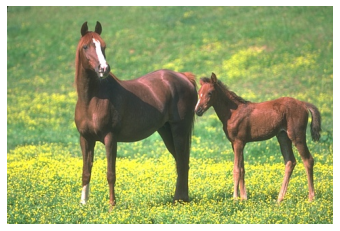

In [4]:
img = cv2.imread('../Deep Learning/home/abdelhaa/Desktop/Deep Learning/Dataset15/Images/113016.jpg')
# img = cv2.imread('starfish.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape
print(w, 'x', h)

# img = cv2.GaussianBlur(img,(5, 5),1, borderType=cv2.BORDER_REPLICATE)

show_inplace(img)

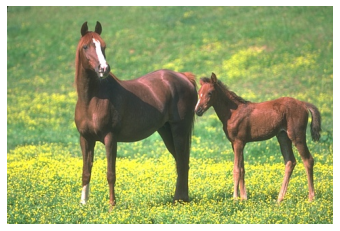

In [5]:
probability = 0.0
for y in range(h):
    for x in range(w):
        if r() <= probability:
            img[y][x][0] = int(r() * 255)
            img[y][x][1] = int(r() * 255)
            img[y][x][2] = int(r() * 255)
show_inplace(img)
img = img/255
lab = rgb2lab(img)

Number of superpixels: 54


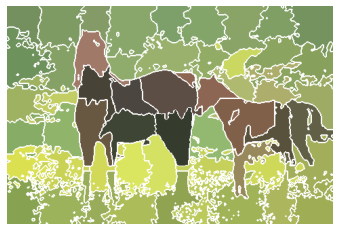

Number of superpixels: 54


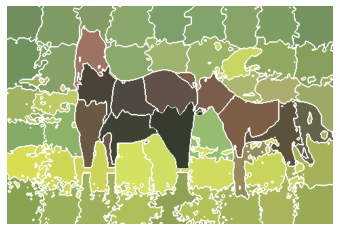

Number of superpixels: 54


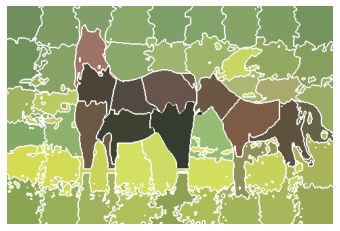

In [6]:
for iteration in range(1, 4):
    superpixels = fslic(lab, initial_num_clusters=60, sp_control=17, max_iterations=iteration)
    print("Number of superpixels:", len(np.unique(superpixels.reshape((h*w, 3)), axis=0)))
    result = lab2rgb(superpixels)
    contours = mark_boundaries(result, np.unique(result.reshape((-1, 3)), axis=0, return_inverse=True)[1].reshape((h, w)), color=[1,1,1,])
    show_inplace(contours)

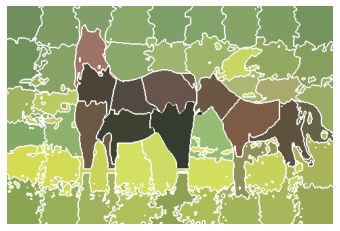

In [7]:
contours = mark_boundaries(result, np.unique(result.reshape((-1, 3)), axis=0, return_inverse=True)[1].reshape((h, w)), color=[1,1,1,])
show_inplace(contours)

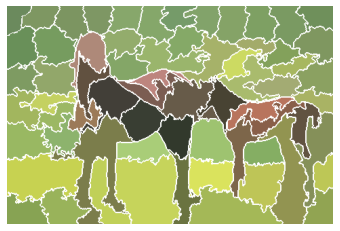

True

In [8]:
COMPACTNESS = 10
slic_result = slic(img, n_segments=100, compactness=COMPACTNESS, start_label=0, max_iter=10)
contours2 = mark_boundaries(color_superpixels(slic_result, img), slic_result, color=[1,1,1])
show_inplace(contours2)

cv2.imwrite('slic{}.png'.format(COMPACTNESS), cv2.cvtColor((255 * contours2).astype(np.uint8), cv2.COLOR_RGB2BGR))

In [9]:
cv2.imwrite('img_noise2.png', cv2.cvtColor((255 * img).astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2.imwrite('fslic_noise2.png', cv2.cvtColor((255 * contours).astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2.imwrite('slic_noise2.png', cv2.cvtColor((255 * contours2).astype(np.uint8), cv2.COLOR_RGB2BGR))

True

In [10]:
visited = np.zeros((h, w), dtype=bool)
markers = np.zeros((h, w), dtype=int)

dx = [-1, 0, 0, 1]
dy = [0, 1, -1, 0]

l = 0
for y in range(h):
    for x in range(w):
        if visited[y][x] == False:
            Q = []
            Q.append([x, y])
            while Q:
                coords = Q.pop(0)
                pop_x = coords[0]
                pop_y = coords[1]
                current_color = result[pop_y][pop_x]
                markers[pop_y][pop_x] = l
                visited[pop_y][pop_x] = True
                for i in range(4):
                    y_ = pop_y+dy[i]
                    x_ = pop_x+dx[i]
                    if y_>=0 and y_<h and x_>=0 and x_<w and (current_color == result[y_][x_]).all() and not visited[y_][x_] and not [x_, y_] in Q:
                        Q.append([x_, y_])
            l+=1

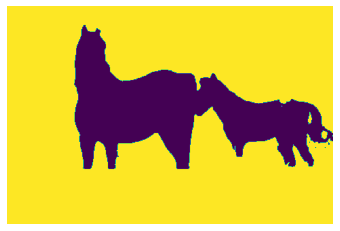

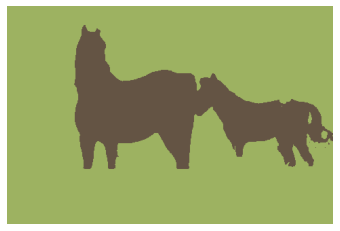

In [11]:
sums, sizes = get_sums_and_sizes(superpixels)

clustered = np.zeros((superpixels.shape[0], superpixels.shape[1]))
markers = np.unique(superpixels.reshape((superpixels.shape[0] * superpixels.shape[1], superpixels.shape[2])), axis=0, return_inverse=True)[1]
markers = markers.reshape((superpixels.shape[0] , superpixels.shape[1]))

error = 1.7e300
res = sizes.copy()

for i in range(100):
    res1, error1 = fcm_superpixels(superpixels, sums, sizes, c=2, m=2)
    if error1 < error:
        error = error1
        res = res1
    

for y in range(superpixels.shape[0]):
    for x in range(superpixels.shape[1]):
        clustered[y][x] = res[markers[y][x]]

colored = color_superpixels(clustered, img)
show_inplace(clustered)
show_inplace(colored)

In [12]:
cv2.imwrite('clustered_113016_fslic.png', cv2.cvtColor((255 * colored).astype(np.uint8), cv2.COLOR_RGB2BGR))

True

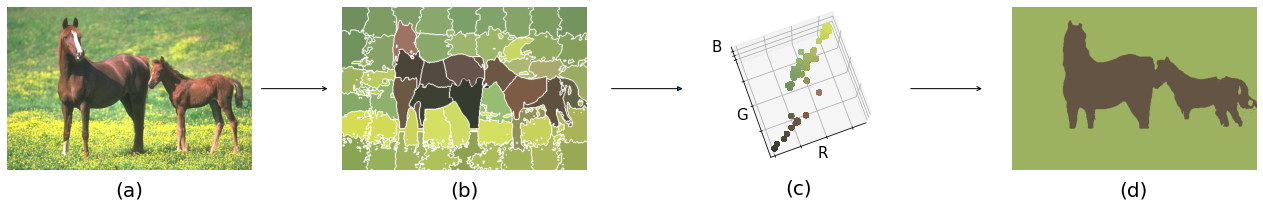

In [13]:
fig = plt.figure(figsize=(23, img.shape[0]//96))
ax1 = plt.subplot2grid((1, 4), (0, 0))
ax1.axis('off')
ax1.set_title('(a)', y=-0.2, fontsize=20)
ax1.imshow(img)

ax2 = plt.subplot2grid((1, 4), (0, 1))
ax2.axis('off')
ax2.set_title('(b)', y=-0.2, fontsize=20)
ax2.imshow(contours)

xy = (500, 160)
xy2 = (-19, 160)
con = ConnectionPatch(
    xyA=xy, coordsA=ax1.transData,
    xyB=xy2, coordsB=ax2.transData,
    arrowstyle="->", shrinkB=5)
fig.add_artist(con)
# ax3 = plt.subplot2grid((1, 5), (0, 2))
# gr = rgb2gray(result).flatten()
# ax3.hist(255*gr, bins=len(np.unique(gr)), color=[0,0,1], rwidth=1)
# ax3.set_xlabel('colour', labelpad=5)
# ax3.set_ylabel('count', labelpad=5)

ax4 = plt.subplot2grid((1, 4), (0, 2), projection='3d')
x = result[:, :, 0].flatten()*255
y = result[:, :, 1].flatten()*255
z = result[:, :, 2].flatten()*255
ax4.scatter(x, y, z, c=result.reshape((-1, 3)))
ax4.view_init(80, 250)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_zticklabels([])
ax4.set_xlabel('R', labelpad=-10, fontsize=15)
ax4.set_ylabel('G', labelpad=-10, fontsize=15)
ax4.set_zlabel('B', labelpad=-10, fontsize=15)
ax4.set_title('(c)', y=-0.2, fontsize=20)

xy = (530, 160)
xy2 = (680, 160)
con = ConnectionPatch(
    xyA=xy, coordsA=ax2.transData,
    xyB=xy2, coordsB=ax2.transData,
    arrowstyle="-|>", shrinkB=5)
fig.add_artist(con)
# ax4.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax4.yaxis.set_major_locator(ticker.MultipleLocator(50))
# ax4.zaxis.set_major_locator(ticker.MultipleLocator(50))
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=6)
# plt.zticks(fontsize=4)

ax5 = plt.subplot2grid((1, 4), (0, 3))
ax5.axis('off')
ax5.imshow(colored)
ax5.set_title('(d)', y=-0.2, fontsize=20)

xy = (-49, 160)
xy2 = (-199, 160)
con = ConnectionPatch(
    xyA=xy2, coordsA=ax5.transData,
    xyB=xy, coordsB=ax5.transData,
    arrowstyle="->", shrinkB=5)
fig.add_artist(con)

plt.show()

In [14]:
fig.savefig("sp_clustering_process.png", format='png', bbox_inches='tight')